# Stellargraph example: Personalised Propagation of Neural Predictions (PPNP) and Approximate PPNP (APPNP) on the CORA citation dataset

Import NetworkX and stellargraph:

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer.ppnp import PPNP
from stellargraph.layer.appnp import APPNP

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [2]:
data_dir = os.path.join("~", "data", "cora")

Load the graph from edgelist (in the order `cited-paper` <- `citing-paper`)

In [3]:
edgelist = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
edgelist["label"] = "cites"

In [4]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

In [5]:
nx.set_node_attributes(Gnx, "paper", "label")

Load the features and subject for the nodes

In [6]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names = feature_names + ["subject"]
node_data = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names
)

We aim to train a graph-ML model that will predict the "subject" attribute on the nodes. These subjects are one of 7 categories:

In [7]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [8]:
train_data, test_data = model_selection.train_test_split(
    node_data, train_size=140, test_size=None, stratify=node_data["subject"]
)
val_data, test_data = model_selection.train_test_split(
    test_data, train_size=500, test_size=None, stratify=test_data["subject"]
)

Note using stratified sampling gives the following counts:

In [9]:
from collections import Counter

Counter(train_data["subject"])

Counter({'Genetic_Algorithms': 22,
         'Theory': 18,
         'Neural_Networks': 42,
         'Case_Based': 16,
         'Reinforcement_Learning': 11,
         'Probabilistic_Methods': 22,
         'Rule_Learning': 9})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [10]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict("records"))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict("records"))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict("records"))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [11]:
node_features = node_data[feature_names]

## Creating the PPNP model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [12]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [13]:
print(G.info())

NetworkXStellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since PPNP is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and the normalized graph Laplacian matrix to the model.

Specifying the `method='ppnp'` argument to the `FullBatchNodeGenerator` will pre-process the adjacency matrix and supply the personalized page rank matrix necessary for PPNP.  The personalized page rank matrix is a dense matrix and so `sparse=False` must be passed to `FullBatchNodeGenerator`. `teleport_probability=0.1` specifies the probability of returning to the starting node in the propogation step as desribed in the paper (alpha in the paper). 

In [14]:
generator = FullBatchNodeGenerator(
    G, method="ppnp", sparse=False, teleport_probability=0.1
)

For training we map only the training nodes returned from our splitter and the target values.

In [15]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each full fully connected layer in the model. In this example we use three fully connected layers with 64,64, and 7 hidden node features at each layer. 
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 
 * `kernel_regularizer=keras.regularizers.l2(0.001)` specifies a penality that prevents the model weights from become too large and helps limit overfitting
 
 #### Note that the size of the final fully connected layer must be equal to the number of classes you are trying to predict.


We create a PPNP model as follows:

In [16]:
ppnp = PPNP(
    layer_sizes=[64, 64, train_targets.shape[-1]],
    activations=["relu", "relu", "relu"],
    generator=generator,
    dropout=0.5,
    kernel_regularizer=keras.regularizers.l2(0.001),
)

x_inp, x_out = ppnp.build()
predictions = keras.layers.Softmax()(x_out)

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `predictions` from the final dense layer

In [17]:
ppnp_model = Model(inputs=x_inp, outputs=predictions)
ppnp_model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [18]:
val_gen = generator.flow(val_data.index, val_targets)

Create callbacks for early stopping (if validation accuracy stops improving) and best model checkpoint saving:

In [19]:
if not os.path.isdir("logs"):
    os.makedirs("logs")

In [20]:
es_callback = EarlyStopping(
    monitor="val_acc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_ppnp_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

Train the model

In [21]:
history = ppnp_model.fit_generator(
    train_gen,
    epochs=80,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/80
Instructions for updating:
Use tf.identity instead.


1/1 - 0s - loss: 2.1599 - acc: 0.0929 - val_loss: 2.0875 - val_acc: 0.3020


Epoch 2/80


1/1 - 0s - loss: 2.0729 - acc: 0.2929 - val_loss: 2.0289 - val_acc: 0.3020


Epoch 3/80


1/1 - 0s - loss: 2.0044 - acc: 0.2929 - val_loss: 1.9817 - val_acc: 0.3020


Epoch 4/80


1/1 - 0s - loss: 1.9740 - acc: 0.3000 - val_loss: 1.9448 - val_acc: 0.3020


Epoch 5/80


1/1 - 0s - loss: 1.9435 - acc: 0.2929 - val_loss: 1.8980 - val_acc: 0.3020


Epoch 6/80


1/1 - 0s - loss: 1.8911 - acc: 0.3071 - val_loss: 1.8500 - val_acc: 0.3020


Epoch 7/80


1/1 - 0s - loss: 1.9128 - acc: 0.3071 - val_loss: 1.8064 - val_acc: 0.3940


Epoch 8/80


1/1 - 0s - loss: 1.8352 - acc: 0.3143 - val_loss: 1.7619 - val_acc: 0.4980


Epoch 9/80


1/1 - 0s - loss: 1.7459 - acc: 0.4571 - val_loss: 1.7043 - val_acc: 0.5540


Epoch 10/80


1/1 - 0s - loss: 1.7510 - acc: 0.4429 - val_loss: 1.6316 - val_acc: 0.5800


Epoch 11/80


1/1 - 0s - loss: 1.6374 - acc: 0.5000 - val_loss: 1.5465 - val_acc: 0.5980


Epoch 12/80


1/1 - 0s - loss: 1.6044 - acc: 0.5000 - val_loss: 1.4637 - val_acc: 0.5940


Epoch 13/80


1/1 - 0s - loss: 1.5055 - acc: 0.5714 - val_loss: 1.3875 - val_acc: 0.5980


Epoch 14/80


1/1 - 0s - loss: 1.4694 - acc: 0.5714 - val_loss: 1.3166 - val_acc: 0.6520


Epoch 15/80


1/1 - 0s - loss: 1.4645 - acc: 0.5214 - val_loss: 1.2547 - val_acc: 0.6940


Epoch 16/80


1/1 - 0s - loss: 1.3094 - acc: 0.6214 - val_loss: 1.2062 - val_acc: 0.7160


Epoch 17/80


1/1 - 0s - loss: 1.3256 - acc: 0.6214 - val_loss: 1.1758 - val_acc: 0.7320


Epoch 18/80


1/1 - 0s - loss: 1.1683 - acc: 0.6857 - val_loss: 1.1537 - val_acc: 0.7260


Epoch 19/80


1/1 - 0s - loss: 1.0887 - acc: 0.7000 - val_loss: 1.1347 - val_acc: 0.7320


Epoch 20/80


1/1 - 0s - loss: 1.1129 - acc: 0.7143 - val_loss: 1.1092 - val_acc: 0.7400


Epoch 21/80


1/1 - 0s - loss: 1.1137 - acc: 0.7500 - val_loss: 1.0891 - val_acc: 0.7460


Epoch 22/80


1/1 - 0s - loss: 0.9502 - acc: 0.7786 - val_loss: 1.0789 - val_acc: 0.7620


Epoch 23/80


1/1 - 0s - loss: 1.0123 - acc: 0.7571 - val_loss: 1.0595 - val_acc: 0.7740


Epoch 24/80


1/1 - 0s - loss: 1.0087 - acc: 0.7357 - val_loss: 1.0430 - val_acc: 0.7840


Epoch 25/80


1/1 - 0s - loss: 1.0182 - acc: 0.7714 - val_loss: 1.0376 - val_acc: 0.7860


Epoch 26/80


1/1 - 0s - loss: 0.9582 - acc: 0.7643 - val_loss: 1.0433 - val_acc: 0.7960


Epoch 27/80


1/1 - 0s - loss: 0.9607 - acc: 0.8000 - val_loss: 1.0343 - val_acc: 0.7840


Epoch 28/80


1/1 - 0s - loss: 0.9276 - acc: 0.8071 - val_loss: 1.0314 - val_acc: 0.7720


Epoch 29/80


1/1 - 0s - loss: 0.9551 - acc: 0.8000 - val_loss: 1.0383 - val_acc: 0.7700


Epoch 30/80


1/1 - 0s - loss: 0.8990 - acc: 0.8000 - val_loss: 1.0472 - val_acc: 0.7680


Epoch 31/80


1/1 - 0s - loss: 0.8820 - acc: 0.8143 - val_loss: 1.0538 - val_acc: 0.7740


Epoch 32/80


1/1 - 0s - loss: 0.9005 - acc: 0.8143 - val_loss: 1.0441 - val_acc: 0.7700


Epoch 33/80


1/1 - 0s - loss: 0.9670 - acc: 0.7857 - val_loss: 1.0319 - val_acc: 0.7700


Epoch 34/80


1/1 - 0s - loss: 0.8599 - acc: 0.8500 - val_loss: 1.0115 - val_acc: 0.7700


Epoch 35/80


1/1 - 0s - loss: 0.8452 - acc: 0.8357 - val_loss: 0.9817 - val_acc: 0.7760


Epoch 36/80


1/1 - 0s - loss: 0.8312 - acc: 0.8357 - val_loss: 0.9644 - val_acc: 0.7800


Epoch 37/80


1/1 - 0s - loss: 0.7943 - acc: 0.8500 - val_loss: 0.9724 - val_acc: 0.7800


Epoch 38/80


1/1 - 0s - loss: 0.9365 - acc: 0.8214 - val_loss: 0.9778 - val_acc: 0.7780


Epoch 39/80


1/1 - 0s - loss: 0.8617 - acc: 0.8214 - val_loss: 0.9711 - val_acc: 0.7840


Epoch 40/80


1/1 - 0s - loss: 0.8251 - acc: 0.8071 - val_loss: 0.9640 - val_acc: 0.7840


Epoch 41/80


1/1 - 0s - loss: 0.8186 - acc: 0.8571 - val_loss: 0.9728 - val_acc: 0.7820


Epoch 42/80


1/1 - 0s - loss: 0.7751 - acc: 0.8500 - val_loss: 0.9932 - val_acc: 0.7800


Epoch 43/80


1/1 - 0s - loss: 0.7727 - acc: 0.8500 - val_loss: 1.0128 - val_acc: 0.7820


Epoch 44/80


1/1 - 0s - loss: 0.8369 - acc: 0.8429 - val_loss: 1.0134 - val_acc: 0.7820


Epoch 45/80


1/1 - 0s - loss: 0.8604 - acc: 0.8143 - val_loss: 0.9930 - val_acc: 0.7760


Epoch 46/80


1/1 - 0s - loss: 0.7866 - acc: 0.8286 - val_loss: 0.9742 - val_acc: 0.7820


Epoch 47/80


1/1 - 0s - loss: 0.7795 - acc: 0.8571 - val_loss: 0.9660 - val_acc: 0.7860


Epoch 48/80


1/1 - 0s - loss: 0.8167 - acc: 0.8214 - val_loss: 0.9593 - val_acc: 0.7880


Epoch 49/80


1/1 - 0s - loss: 0.8022 - acc: 0.8357 - val_loss: 0.9590 - val_acc: 0.7860


Epoch 50/80


1/1 - 0s - loss: 0.7633 - acc: 0.8286 - val_loss: 0.9644 - val_acc: 0.7820


Epoch 51/80


1/1 - 0s - loss: 0.6852 - acc: 0.8714 - val_loss: 0.9684 - val_acc: 0.7820


Epoch 52/80


1/1 - 0s - loss: 0.8340 - acc: 0.8286 - val_loss: 0.9713 - val_acc: 0.7800


Epoch 53/80


1/1 - 0s - loss: 0.8443 - acc: 0.8214 - val_loss: 0.9769 - val_acc: 0.7900


Epoch 54/80


1/1 - 0s - loss: 0.7172 - acc: 0.8429 - val_loss: 0.9850 - val_acc: 0.7840


Epoch 55/80


1/1 - 0s - loss: 0.7857 - acc: 0.8643 - val_loss: 0.9908 - val_acc: 0.7860


Epoch 56/80


1/1 - 0s - loss: 0.8716 - acc: 0.8143 - val_loss: 0.9983 - val_acc: 0.7880


Epoch 57/80


1/1 - 0s - loss: 0.8405 - acc: 0.8143 - val_loss: 0.9929 - val_acc: 0.7900


Epoch 58/80


1/1 - 0s - loss: 0.7329 - acc: 0.8643 - val_loss: 0.9807 - val_acc: 0.7840


Epoch 59/80


1/1 - 0s - loss: 0.7431 - acc: 0.8929 - val_loss: 0.9720 - val_acc: 0.7700


Epoch 60/80


1/1 - 0s - loss: 0.7624 - acc: 0.8429 - val_loss: 0.9630 - val_acc: 0.7800


Epoch 61/80


1/1 - 0s - loss: 0.7111 - acc: 0.8714 - val_loss: 0.9588 - val_acc: 0.7800


Epoch 62/80


1/1 - 0s - loss: 0.6725 - acc: 0.8857 - val_loss: 0.9548 - val_acc: 0.7800


Epoch 63/80


1/1 - 0s - loss: 0.7147 - acc: 0.8571 - val_loss: 0.9537 - val_acc: 0.7840


Epoch 64/80


1/1 - 0s - loss: 0.7115 - acc: 0.8714 - val_loss: 0.9520 - val_acc: 0.7860


Epoch 65/80


1/1 - 0s - loss: 0.6966 - acc: 0.8643 - val_loss: 0.9535 - val_acc: 0.8000


Epoch 66/80


1/1 - 0s - loss: 0.7248 - acc: 0.8643 - val_loss: 0.9520 - val_acc: 0.8060


Epoch 67/80


1/1 - 0s - loss: 0.7633 - acc: 0.8214 - val_loss: 0.9521 - val_acc: 0.7980


Epoch 68/80


1/1 - 0s - loss: 0.6003 - acc: 0.8857 - val_loss: 0.9563 - val_acc: 0.8020


Epoch 69/80


1/1 - 0s - loss: 0.6435 - acc: 0.8714 - val_loss: 0.9592 - val_acc: 0.8200


Epoch 70/80


1/1 - 0s - loss: 0.5962 - acc: 0.9071 - val_loss: 0.9577 - val_acc: 0.8240


Epoch 71/80


1/1 - 0s - loss: 0.7508 - acc: 0.8643 - val_loss: 0.9514 - val_acc: 0.8300


Epoch 72/80


1/1 - 0s - loss: 0.7667 - acc: 0.8500 - val_loss: 0.9442 - val_acc: 0.8280


Epoch 73/80


1/1 - 0s - loss: 0.7510 - acc: 0.8714 - val_loss: 0.9344 - val_acc: 0.8180


Epoch 74/80


1/1 - 0s - loss: 0.6949 - acc: 0.8786 - val_loss: 0.9287 - val_acc: 0.8200


Epoch 75/80


1/1 - 0s - loss: 0.6527 - acc: 0.9143 - val_loss: 0.9273 - val_acc: 0.8160


Epoch 76/80


1/1 - 0s - loss: 0.6168 - acc: 0.8929 - val_loss: 0.9322 - val_acc: 0.8040


Epoch 77/80


1/1 - 0s - loss: 0.6317 - acc: 0.9000 - val_loss: 0.9461 - val_acc: 0.7920


Epoch 78/80


1/1 - 0s - loss: 0.7114 - acc: 0.8643 - val_loss: 0.9651 - val_acc: 0.7880


Epoch 79/80


1/1 - 0s - loss: 0.6116 - acc: 0.8786 - val_loss: 0.9693 - val_acc: 0.7960


Epoch 80/80


1/1 - 0s - loss: 0.6332 - acc: 0.8786 - val_loss: 0.9705 - val_acc: 0.8180


Plot the training history:

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

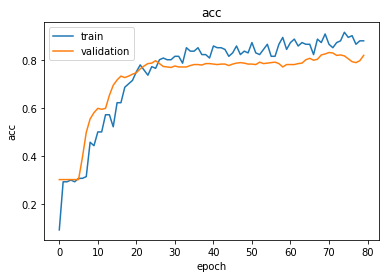

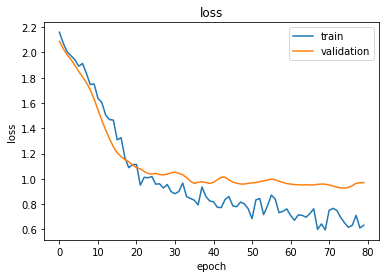

In [23]:
plot_history(history)

Reload the saved weights of the best model found during the training (according to validation accuracy)

In [24]:
ppnp_model.load_weights("logs/best_ppnp_model.h5")

Evaluate the best model on the test set

In [25]:
test_gen = generator.flow(test_data.index, test_targets)

In [26]:
test_metrics = ppnp_model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(ppnp_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.9411
	acc: 0.8167


## Using the Approximate PPNP Model

Lets repeat the training and testing steps with the APPNP model using the same dataset. The downside of the PPNP is that you have to invert the adjacency matrix - which is time inneficient for large graphs - and store that invert matrix - which is space innefficient. The approximate model avoids this issue by using a clever mathematical trick. 

The APPNP model uses the normalized graph Laplacian. To get the normalized graph Laplacian we create a new `FullBatchNodeGenerator` and set `method="gcn"`. We have the option of choosing `sparse=True` or `sparse=False` but will use `sparse=True` for memory efficiency.

In [27]:
generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)

train_gen = generator.flow(train_data.index, train_targets)
val_gen = generator.flow(val_data.index, val_targets)
test_gen = generator.flow(test_data.index, test_targets)

appnp = APPNP(
    layer_sizes=[64, 64, train_targets.shape[-1]],
    activations=["relu", "relu", "relu"],
    bias=True,
    generator=generator,
    teleport_probability=0.1,
    dropout=0.5,
    kernel_regularizer=keras.regularizers.l2(0.001),
)

x_inp, x_out = appnp.build()
predictions = keras.layers.Softmax()(x_out)

appnp_model = keras.models.Model(inputs=x_inp, outputs=predictions)
appnp_model.compile(
    loss="categorical_crossentropy",
    metrics=["acc"],
    optimizer=keras.optimizers.Adam(lr=0.01),
)

es_callback = EarlyStopping(
    monitor="val_acc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_appnp_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

history = appnp_model.fit_generator(
    train_gen,
    epochs=120,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Using GCN (local pooling) filters...


Epoch 1/120


1/1 - 0s - loss: 2.1413 - acc: 0.1786 - val_loss: 2.0759 - val_acc: 0.3020


Epoch 2/120


1/1 - 0s - loss: 2.0987 - acc: 0.2286 - val_loss: 2.0169 - val_acc: 0.3020


Epoch 3/120


1/1 - 0s - loss: 2.0216 - acc: 0.3286 - val_loss: 1.9648 - val_acc: 0.3020


Epoch 4/120


1/1 - 0s - loss: 1.9878 - acc: 0.2643 - val_loss: 1.9266 - val_acc: 0.3020


Epoch 5/120


1/1 - 0s - loss: 1.9891 - acc: 0.2929 - val_loss: 1.9085 - val_acc: 0.3100


Epoch 6/120


1/1 - 0s - loss: 1.9280 - acc: 0.3429 - val_loss: 1.8871 - val_acc: 0.4220


Epoch 7/120


1/1 - 0s - loss: 1.9102 - acc: 0.3429 - val_loss: 1.8569 - val_acc: 0.4500


Epoch 8/120


1/1 - 0s - loss: 1.8720 - acc: 0.3929 - val_loss: 1.8272 - val_acc: 0.4760


Epoch 9/120


1/1 - 0s - loss: 1.7714 - acc: 0.4714 - val_loss: 1.7689 - val_acc: 0.5020


Epoch 10/120


1/1 - 0s - loss: 1.7883 - acc: 0.4571 - val_loss: 1.6912 - val_acc: 0.5180


Epoch 11/120


1/1 - 0s - loss: 1.7303 - acc: 0.4786 - val_loss: 1.6159 - val_acc: 0.5220


Epoch 12/120


1/1 - 0s - loss: 1.6284 - acc: 0.4857 - val_loss: 1.5556 - val_acc: 0.5200


Epoch 13/120


1/1 - 0s - loss: 1.6096 - acc: 0.4571 - val_loss: 1.4922 - val_acc: 0.5520


Epoch 14/120


1/1 - 0s - loss: 1.6457 - acc: 0.4714 - val_loss: 1.4272 - val_acc: 0.6240


Epoch 15/120


1/1 - 0s - loss: 1.5663 - acc: 0.5500 - val_loss: 1.3796 - val_acc: 0.6300


Epoch 16/120


1/1 - 0s - loss: 1.5120 - acc: 0.5429 - val_loss: 1.3381 - val_acc: 0.6340


Epoch 17/120


1/1 - 0s - loss: 1.5045 - acc: 0.5714 - val_loss: 1.3023 - val_acc: 0.6440


Epoch 18/120


1/1 - 0s - loss: 1.4460 - acc: 0.5429 - val_loss: 1.2748 - val_acc: 0.7080


Epoch 19/120


1/1 - 0s - loss: 1.3942 - acc: 0.6143 - val_loss: 1.2506 - val_acc: 0.7620


Epoch 20/120


1/1 - 0s - loss: 1.3666 - acc: 0.6500 - val_loss: 1.2265 - val_acc: 0.7740


Epoch 21/120


1/1 - 0s - loss: 1.5152 - acc: 0.6286 - val_loss: 1.2125 - val_acc: 0.7580


Epoch 22/120


1/1 - 0s - loss: 1.3239 - acc: 0.6214 - val_loss: 1.1989 - val_acc: 0.7460


Epoch 23/120


1/1 - 0s - loss: 1.3540 - acc: 0.6071 - val_loss: 1.1894 - val_acc: 0.7520


Epoch 24/120


1/1 - 0s - loss: 1.3109 - acc: 0.6714 - val_loss: 1.1858 - val_acc: 0.7320


Epoch 25/120


1/1 - 0s - loss: 1.1982 - acc: 0.7214 - val_loss: 1.1751 - val_acc: 0.7460


Epoch 26/120


1/1 - 0s - loss: 1.3504 - acc: 0.6857 - val_loss: 1.1750 - val_acc: 0.7440


Epoch 27/120


1/1 - 0s - loss: 1.1799 - acc: 0.7571 - val_loss: 1.1680 - val_acc: 0.7460


Epoch 28/120


1/1 - 0s - loss: 1.2975 - acc: 0.6714 - val_loss: 1.1511 - val_acc: 0.7520


Epoch 29/120


1/1 - 0s - loss: 1.1338 - acc: 0.7286 - val_loss: 1.1490 - val_acc: 0.7580


Epoch 30/120


1/1 - 0s - loss: 1.2208 - acc: 0.7571 - val_loss: 1.1532 - val_acc: 0.7700


Epoch 31/120


1/1 - 0s - loss: 1.1607 - acc: 0.7000 - val_loss: 1.1396 - val_acc: 0.7760


Epoch 32/120


1/1 - 0s - loss: 1.0924 - acc: 0.7857 - val_loss: 1.1135 - val_acc: 0.7740


Epoch 33/120


1/1 - 0s - loss: 1.1024 - acc: 0.7643 - val_loss: 1.0881 - val_acc: 0.7800


Epoch 34/120


1/1 - 0s - loss: 1.0162 - acc: 0.8071 - val_loss: 1.0836 - val_acc: 0.7740


Epoch 35/120


1/1 - 0s - loss: 1.1178 - acc: 0.7714 - val_loss: 1.0922 - val_acc: 0.7720


Epoch 36/120


1/1 - 0s - loss: 1.1809 - acc: 0.7357 - val_loss: 1.0989 - val_acc: 0.7800


Epoch 37/120


1/1 - 0s - loss: 1.0587 - acc: 0.7714 - val_loss: 1.0948 - val_acc: 0.7780


Epoch 38/120


1/1 - 0s - loss: 0.9302 - acc: 0.7714 - val_loss: 1.0806 - val_acc: 0.7840


Epoch 39/120


1/1 - 0s - loss: 1.0706 - acc: 0.8143 - val_loss: 1.0654 - val_acc: 0.7900


Epoch 40/120


1/1 - 0s - loss: 0.9658 - acc: 0.7857 - val_loss: 1.0604 - val_acc: 0.7880


Epoch 41/120


1/1 - 0s - loss: 0.9261 - acc: 0.8286 - val_loss: 1.0573 - val_acc: 0.7960


Epoch 42/120


1/1 - 0s - loss: 1.0579 - acc: 0.7929 - val_loss: 1.0654 - val_acc: 0.7980


Epoch 43/120


1/1 - 0s - loss: 0.9831 - acc: 0.8286 - val_loss: 1.0838 - val_acc: 0.7860


Epoch 44/120


1/1 - 0s - loss: 1.0107 - acc: 0.7857 - val_loss: 1.0941 - val_acc: 0.7820


Epoch 45/120


1/1 - 0s - loss: 1.0830 - acc: 0.7857 - val_loss: 1.0940 - val_acc: 0.7840


Epoch 46/120


1/1 - 0s - loss: 0.9700 - acc: 0.8143 - val_loss: 1.0864 - val_acc: 0.7840


Epoch 47/120


1/1 - 0s - loss: 0.9382 - acc: 0.8714 - val_loss: 1.0783 - val_acc: 0.7940


Epoch 48/120


1/1 - 0s - loss: 0.9849 - acc: 0.8643 - val_loss: 1.0696 - val_acc: 0.7900


Epoch 49/120


1/1 - 0s - loss: 1.0407 - acc: 0.8071 - val_loss: 1.0678 - val_acc: 0.7900


Epoch 50/120


1/1 - 0s - loss: 0.8427 - acc: 0.8643 - val_loss: 1.0681 - val_acc: 0.7920


Epoch 51/120


1/1 - 0s - loss: 0.9414 - acc: 0.8071 - val_loss: 1.0720 - val_acc: 0.7820


Epoch 52/120


1/1 - 0s - loss: 0.9693 - acc: 0.8786 - val_loss: 1.0774 - val_acc: 0.7840


Epoch 53/120


1/1 - 0s - loss: 0.8644 - acc: 0.8714 - val_loss: 1.0795 - val_acc: 0.7880


Epoch 54/120


1/1 - 0s - loss: 1.0187 - acc: 0.8500 - val_loss: 1.0806 - val_acc: 0.7860


Epoch 55/120


1/1 - 0s - loss: 0.8931 - acc: 0.8214 - val_loss: 1.0743 - val_acc: 0.7840


Epoch 56/120


1/1 - 0s - loss: 0.9598 - acc: 0.8643 - val_loss: 1.0671 - val_acc: 0.7900


Epoch 57/120


1/1 - 0s - loss: 0.9073 - acc: 0.8643 - val_loss: 1.0700 - val_acc: 0.7920


Epoch 58/120


1/1 - 0s - loss: 0.8692 - acc: 0.8143 - val_loss: 1.0801 - val_acc: 0.7900


Epoch 59/120


1/1 - 0s - loss: 0.8511 - acc: 0.8500 - val_loss: 1.0876 - val_acc: 0.7820


Epoch 60/120


1/1 - 0s - loss: 0.8888 - acc: 0.8500 - val_loss: 1.0888 - val_acc: 0.7780


Epoch 61/120


1/1 - 0s - loss: 1.0101 - acc: 0.8429 - val_loss: 1.0844 - val_acc: 0.7820


Epoch 62/120


1/1 - 0s - loss: 0.8652 - acc: 0.8714 - val_loss: 1.0802 - val_acc: 0.7900


Epoch 63/120


1/1 - 0s - loss: 0.8459 - acc: 0.8429 - val_loss: 1.0787 - val_acc: 0.7880


Epoch 64/120


1/1 - 0s - loss: 0.8942 - acc: 0.8857 - val_loss: 1.0767 - val_acc: 0.7900


Epoch 65/120


1/1 - 0s - loss: 0.8255 - acc: 0.8643 - val_loss: 1.0738 - val_acc: 0.7820


Epoch 66/120


1/1 - 0s - loss: 0.9278 - acc: 0.8357 - val_loss: 1.0772 - val_acc: 0.7800


Epoch 67/120


1/1 - 0s - loss: 0.8461 - acc: 0.8643 - val_loss: 1.0847 - val_acc: 0.7700


Epoch 68/120


1/1 - 0s - loss: 0.8514 - acc: 0.8786 - val_loss: 1.0899 - val_acc: 0.7720


Epoch 69/120


1/1 - 0s - loss: 0.8200 - acc: 0.8786 - val_loss: 1.0872 - val_acc: 0.7740


Epoch 70/120


1/1 - 0s - loss: 0.8675 - acc: 0.8571 - val_loss: 1.0864 - val_acc: 0.7740


Epoch 71/120


1/1 - 0s - loss: 0.8834 - acc: 0.8500 - val_loss: 1.0743 - val_acc: 0.7760


Epoch 72/120


1/1 - 0s - loss: 1.0193 - acc: 0.8500 - val_loss: 1.0653 - val_acc: 0.7800


Epoch 73/120


1/1 - 0s - loss: 0.8550 - acc: 0.8857 - val_loss: 1.0591 - val_acc: 0.7820


Epoch 74/120


1/1 - 0s - loss: 0.8386 - acc: 0.8786 - val_loss: 1.0574 - val_acc: 0.7860


Epoch 75/120


1/1 - 0s - loss: 0.9507 - acc: 0.8143 - val_loss: 1.0520 - val_acc: 0.7860


Epoch 76/120


1/1 - 0s - loss: 0.8325 - acc: 0.8429 - val_loss: 1.0510 - val_acc: 0.7840


Epoch 77/120


1/1 - 0s - loss: 0.8678 - acc: 0.8643 - val_loss: 1.0519 - val_acc: 0.7820


Epoch 78/120


1/1 - 0s - loss: 0.9469 - acc: 0.8357 - val_loss: 1.0549 - val_acc: 0.7860


Epoch 79/120


1/1 - 0s - loss: 0.8085 - acc: 0.8714 - val_loss: 1.0594 - val_acc: 0.7800


Epoch 80/120


1/1 - 0s - loss: 0.8615 - acc: 0.8500 - val_loss: 1.0660 - val_acc: 0.7720


Epoch 81/120


1/1 - 0s - loss: 0.8518 - acc: 0.8786 - val_loss: 1.0751 - val_acc: 0.7820


Epoch 82/120


1/1 - 0s - loss: 0.9459 - acc: 0.8500 - val_loss: 1.0832 - val_acc: 0.7840


Epoch 83/120


1/1 - 0s - loss: 0.9023 - acc: 0.8571 - val_loss: 1.0799 - val_acc: 0.7880


Epoch 84/120


1/1 - 0s - loss: 0.9139 - acc: 0.8714 - val_loss: 1.0885 - val_acc: 0.7800


Epoch 85/120


1/1 - 0s - loss: 0.8655 - acc: 0.8643 - val_loss: 1.0924 - val_acc: 0.7780


Epoch 86/120


1/1 - 0s - loss: 0.8874 - acc: 0.8500 - val_loss: 1.0871 - val_acc: 0.7780


Epoch 87/120


1/1 - 0s - loss: 0.7991 - acc: 0.8786 - val_loss: 1.0857 - val_acc: 0.7760


Epoch 88/120


1/1 - 0s - loss: 1.0519 - acc: 0.8143 - val_loss: 1.0950 - val_acc: 0.7800


Epoch 89/120


1/1 - 0s - loss: 0.7790 - acc: 0.9071 - val_loss: 1.1005 - val_acc: 0.7780


Epoch 90/120


1/1 - 0s - loss: 0.8279 - acc: 0.8357 - val_loss: 1.1037 - val_acc: 0.7760


Epoch 91/120


1/1 - 0s - loss: 0.7695 - acc: 0.8857 - val_loss: 1.1071 - val_acc: 0.7780


Epoch 92/120


1/1 - 0s - loss: 0.8568 - acc: 0.8643 - val_loss: 1.1148 - val_acc: 0.7760


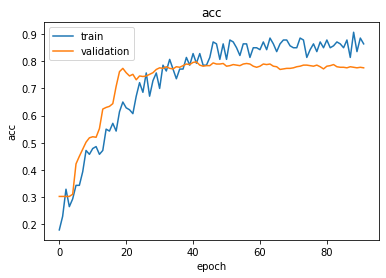

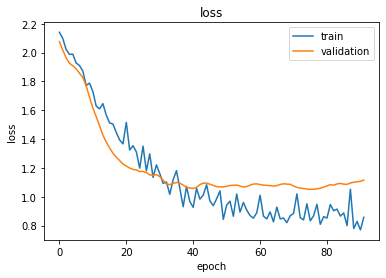

In [28]:
plot_history(history)

In [29]:
appnp_model.load_weights("logs/best_appnp_model.h5")
test_metrics = appnp_model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(appnp_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.0511
	acc: 0.7940


### Scalable APPNP Training

Now we're going to exploit the structure of PPNP for scalable training. PPNP consists of a fully-connected neural network followed by a graph propogation step. For each node, the fully-connected network outputs a score for each class and the propogaiton step basically takes a weighted average of scores of nearby nodes (closer nodes are weighted higher). 

Above, we trained the whole network end-to-end which obtains the most accurate results but  requires us to load the entire graph onto our GPU memory. This is because we need the entire graph for the propogation step. Unfortunately, this limits the graph size by our GPU memory. To get around this, we can train the fully-connected network separately and once we have a trained fully connected network we can add the graph propagation step.  The advantage of this approach is that we can train on batches of node features instead of the entire graph.

The model in the propagation step can be any keras model trained on node features to predict the target classes. In this example we use a fully connected neural network with bag of word features as input. We could easily swap out the bag of words features for the complete text and replace the fully connected network with a state-of-the-art NLP model (for example BERT [1]), fine-tune the model and propagate its predictions.


<br>

1. Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. https://arxiv.org/abs/1810.04805

First we create and train a fully connected model.

In [30]:
model = keras.models.Model()

in_layer = layers.Input(shape=(len(feature_names),))

layer = layers.Dropout(0.5)(in_layer)
layer = layers.Dense(64, activation="relu", kernel_regularizer="l2")(layer)
layer = layers.Dropout(0.5)(layer)
layer = layers.Dense(64, activation="relu", kernel_regularizer="l2")(layer)
layer = layers.Dropout(0.5)(layer)

# note the dimension of the output should equal the number of classes to predict!
layer = layers.Dense(train_targets.shape[-1], activation="relu")(layer)
layer = layers.Softmax()(layer)

fully_connected_model = keras.models.Model(inputs=in_layer, outputs=layer)

fully_connected_model.compile(
    loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizers.Adam(lr=0.01)
)

# the inputs are just the node features
X_train = train_data[feature_names].values.astype(np.float32)
X_val = val_data[feature_names].values.astype(np.float32)

In [31]:
es_callback = EarlyStopping(
    monitor="val_acc", patience=50
)  # patience is the number of epochs to wait before early stopping in case of no further improvement

mc_callback = ModelCheckpoint(
    "logs/best_fc_model.h5",
    monitor="val_acc",
    save_best_only=True,
    save_weights_only=True,
)

history = fully_connected_model.fit(
    X_train,
    train_targets,
    validation_data=(X_val, val_targets),
    epochs=2000,
    batch_size=200,
    shuffle=True,  # we can shuffle the data here as
    callbacks=[es_callback, mc_callback],
)  # we're only working with node features

Train on 140 samples, validate on 500 samples
Epoch 1/2000


140/140 [==============================] - 1s 6ms/sample - loss: 3.8485 - acc: 0.1000 - val_loss: 3.3083 - val_acc: 0.1900


Epoch 2/2000
140/140 [==============================] - 0s 178us/sample - loss: 3.3217 - acc: 0.1714 - val_loss: 2.9498 - val_acc: 0.3040


Epoch 3/2000
140/140 [==============================] - 0s 208us/sample - loss: 2.9493 - acc: 0.1643 - val_loss: 2.7084 - val_acc: 0.3220


Epoch 4/2000
140/140 [==============================] - 0s 159us/sample - loss: 2.6636 - acc: 0.3857 - val_loss: 2.5488 - val_acc: 0.3120


Epoch 5/2000
140/140 [==============================] - 0s 164us/sample - loss: 2.4872 - acc: 0.3500 - val_loss: 2.4442 - val_acc: 0.3040


Epoch 6/2000
140/140 [==============================] - 0s 168us/sample - loss: 2.3739 - acc: 0.3929 - val_loss: 2.3771 - val_acc: 0.3040


Epoch 7/2000
140/140 [==============================] - 0s 165us/sample - loss: 2.2847 - acc: 0.3786 - val_loss: 2.3321 - val_acc: 0.3020


Epoch 8/2000
140/140 [==============================] - 0s 179us/sample - loss: 2.2006 - acc: 0.3714 - val_loss: 2.3000 - val_acc: 0.3020


Epoch 9/2000
140/140 [==============================] - 0s 172us/sample - loss: 2.1878 - acc: 0.3929 - val_loss: 2.2725 - val_acc: 0.3080


Epoch 10/2000
140/140 [==============================] - 0s 166us/sample - loss: 2.0464 - acc: 0.4429 - val_loss: 2.2426 - val_acc: 0.3180


Epoch 11/2000


140/140 [==============================] - 0s 231us/sample - loss: 2.0199 - acc: 0.4143 - val_loss: 2.2011 - val_acc: 0.3560


Epoch 12/2000


140/140 [==============================] - 0s 243us/sample - loss: 1.9192 - acc: 0.4429 - val_loss: 2.1461 - val_acc: 0.4000


Epoch 13/2000


140/140 [==============================] - 0s 227us/sample - loss: 1.8648 - acc: 0.5000 - val_loss: 2.0863 - val_acc: 0.4600


Epoch 14/2000


140/140 [==============================] - 0s 199us/sample - loss: 1.7401 - acc: 0.5929 - val_loss: 2.0268 - val_acc: 0.4920


Epoch 15/2000


140/140 [==============================] - 0s 203us/sample - loss: 1.6906 - acc: 0.6071 - val_loss: 1.9727 - val_acc: 0.5280


Epoch 16/2000


140/140 [==============================] - 0s 198us/sample - loss: 1.6083 - acc: 0.6429 - val_loss: 1.9279 - val_acc: 0.5520


Epoch 17/2000


140/140 [==============================] - 0s 193us/sample - loss: 1.5176 - acc: 0.7429 - val_loss: 1.8930 - val_acc: 0.5600


Epoch 18/2000


140/140 [==============================] - 0s 202us/sample - loss: 1.4444 - acc: 0.7071 - val_loss: 1.8686 - val_acc: 0.5660


Epoch 19/2000
140/140 [==============================] - 0s 140us/sample - loss: 1.3737 - acc: 0.7643 - val_loss: 1.8576 - val_acc: 0.5540


Epoch 20/2000


140/140 [==============================] - 0s 141us/sample - loss: 1.3440 - acc: 0.7429 - val_loss: 1.8541 - val_acc: 0.5580


Epoch 21/2000


140/140 [==============================] - 0s 146us/sample - loss: 1.3335 - acc: 0.7643 - val_loss: 1.8636 - val_acc: 0.5620


Epoch 22/2000
140/140 [==============================] - 0s 144us/sample - loss: 1.3222 - acc: 0.7714 - val_loss: 1.8613 - val_acc: 0.5620


Epoch 23/2000


140/140 [==============================] - 0s 196us/sample - loss: 1.2884 - acc: 0.7929 - val_loss: 1.8608 - val_acc: 0.5840


Epoch 24/2000


140/140 [==============================] - 0s 193us/sample - loss: 1.1907 - acc: 0.8500 - val_loss: 1.8575 - val_acc: 0.5920


Epoch 25/2000


140/140 [==============================] - 0s 187us/sample - loss: 1.1725 - acc: 0.8357 - val_loss: 1.8572 - val_acc: 0.6020


Epoch 26/2000


140/140 [==============================] - 0s 186us/sample - loss: 1.2528 - acc: 0.8000 - val_loss: 1.8392 - val_acc: 0.6160


Epoch 27/2000


140/140 [==============================] - 0s 185us/sample - loss: 1.1431 - acc: 0.8786 - val_loss: 1.8257 - val_acc: 0.6380


Epoch 28/2000


140/140 [==============================] - 0s 190us/sample - loss: 1.2546 - acc: 0.8286 - val_loss: 1.8161 - val_acc: 0.6400


Epoch 29/2000


140/140 [==============================] - 0s 139us/sample - loss: 1.0875 - acc: 0.9000 - val_loss: 1.8147 - val_acc: 0.6360


Epoch 30/2000


140/140 [==============================] - 0s 171us/sample - loss: 1.1210 - acc: 0.8571 - val_loss: 1.8179 - val_acc: 0.6300


Epoch 31/2000


140/140 [==============================] - 0s 155us/sample - loss: 1.1788 - acc: 0.8500 - val_loss: 1.8190 - val_acc: 0.6280


Epoch 32/2000
140/140 [==============================] - 0s 148us/sample - loss: 1.0932 - acc: 0.8786 - val_loss: 1.8256 - val_acc: 0.6180


Epoch 33/2000


140/140 [==============================] - 0s 150us/sample - loss: 1.0502 - acc: 0.8929 - val_loss: 1.8341 - val_acc: 0.6160


Epoch 34/2000


140/140 [==============================] - 0s 152us/sample - loss: 1.0944 - acc: 0.8500 - val_loss: 1.8452 - val_acc: 0.5920


Epoch 35/2000


140/140 [==============================] - 0s 157us/sample - loss: 1.0786 - acc: 0.8714 - val_loss: 1.8448 - val_acc: 0.5980


Epoch 36/2000


140/140 [==============================] - 0s 151us/sample - loss: 1.1030 - acc: 0.8571 - val_loss: 1.8330 - val_acc: 0.6020


Epoch 37/2000
140/140 [==============================] - 0s 141us/sample - loss: 1.0702 - acc: 0.8643 - val_loss: 1.8206 - val_acc: 0.6060


Epoch 38/2000


140/140 [==============================] - 0s 144us/sample - loss: 1.1255 - acc: 0.8643 - val_loss: 1.8021 - val_acc: 0.6080


Epoch 39/2000


140/140 [==============================] - 0s 142us/sample - loss: 1.0457 - acc: 0.8786 - val_loss: 1.7885 - val_acc: 0.6080


Epoch 40/2000


140/140 [==============================] - 0s 143us/sample - loss: 1.0932 - acc: 0.8500 - val_loss: 1.7775 - val_acc: 0.6220


Epoch 41/2000


140/140 [==============================] - 0s 137us/sample - loss: 1.0922 - acc: 0.8500 - val_loss: 1.7753 - val_acc: 0.6220


Epoch 42/2000


140/140 [==============================] - 0s 136us/sample - loss: 1.0114 - acc: 0.8857 - val_loss: 1.7766 - val_acc: 0.6240


Epoch 43/2000


140/140 [==============================] - 0s 194us/sample - loss: 1.0643 - acc: 0.8643 - val_loss: 1.7790 - val_acc: 0.6300


Epoch 44/2000


140/140 [==============================] - 0s 174us/sample - loss: 1.0742 - acc: 0.8714 - val_loss: 1.7812 - val_acc: 0.6200


Epoch 45/2000


140/140 [==============================] - 0s 147us/sample - loss: 1.0769 - acc: 0.8500 - val_loss: 1.7882 - val_acc: 0.6000


Epoch 46/2000


140/140 [==============================] - 0s 149us/sample - loss: 1.0593 - acc: 0.8429 - val_loss: 1.8014 - val_acc: 0.5900


Epoch 47/2000


140/140 [==============================] - 0s 146us/sample - loss: 1.0477 - acc: 0.8714 - val_loss: 1.8197 - val_acc: 0.5800


Epoch 48/2000


140/140 [==============================] - 0s 146us/sample - loss: 1.0045 - acc: 0.8929 - val_loss: 1.8303 - val_acc: 0.5760


Epoch 49/2000


140/140 [==============================] - 0s 156us/sample - loss: 0.9886 - acc: 0.8714 - val_loss: 1.8325 - val_acc: 0.5760


Epoch 50/2000


140/140 [==============================] - 0s 140us/sample - loss: 1.0141 - acc: 0.8571 - val_loss: 1.8354 - val_acc: 0.5680


Epoch 51/2000


140/140 [==============================] - 0s 141us/sample - loss: 1.0230 - acc: 0.8857 - val_loss: 1.8196 - val_acc: 0.5680


Epoch 52/2000
140/140 [==============================] - 0s 146us/sample - loss: 1.0200 - acc: 0.8571 - val_loss: 1.8048 - val_acc: 0.5840


Epoch 53/2000


140/140 [==============================] - 0s 136us/sample - loss: 1.0607 - acc: 0.8500 - val_loss: 1.7887 - val_acc: 0.5980


Epoch 54/2000


140/140 [==============================] - 0s 139us/sample - loss: 0.9957 - acc: 0.8714 - val_loss: 1.7808 - val_acc: 0.5880


Epoch 55/2000


140/140 [==============================] - 0s 146us/sample - loss: 0.9454 - acc: 0.9071 - val_loss: 1.7732 - val_acc: 0.5860


Epoch 56/2000


140/140 [==============================] - 0s 150us/sample - loss: 1.0346 - acc: 0.8429 - val_loss: 1.7634 - val_acc: 0.5920


Epoch 57/2000


140/140 [==============================] - 0s 143us/sample - loss: 1.0966 - acc: 0.8214 - val_loss: 1.7534 - val_acc: 0.6000


Epoch 58/2000


140/140 [==============================] - 0s 154us/sample - loss: 1.0187 - acc: 0.8714 - val_loss: 1.7507 - val_acc: 0.6000


Epoch 59/2000


140/140 [==============================] - 0s 159us/sample - loss: 0.9772 - acc: 0.8714 - val_loss: 1.7514 - val_acc: 0.6000


Epoch 60/2000


140/140 [==============================] - 0s 146us/sample - loss: 0.9008 - acc: 0.9000 - val_loss: 1.7546 - val_acc: 0.6020


Epoch 61/2000


140/140 [==============================] - 0s 147us/sample - loss: 0.9517 - acc: 0.8786 - val_loss: 1.7643 - val_acc: 0.5920


Epoch 62/2000


140/140 [==============================] - 0s 142us/sample - loss: 0.9918 - acc: 0.8643 - val_loss: 1.7757 - val_acc: 0.5860


Epoch 63/2000


140/140 [==============================] - 0s 148us/sample - loss: 0.9684 - acc: 0.8786 - val_loss: 1.8014 - val_acc: 0.5660


Epoch 64/2000


140/140 [==============================] - 0s 144us/sample - loss: 1.0324 - acc: 0.8286 - val_loss: 1.8038 - val_acc: 0.5760


Epoch 65/2000


140/140 [==============================] - 0s 151us/sample - loss: 1.0256 - acc: 0.8571 - val_loss: 1.7990 - val_acc: 0.5840


Epoch 66/2000


140/140 [==============================] - 0s 145us/sample - loss: 0.9821 - acc: 0.8786 - val_loss: 1.7833 - val_acc: 0.5940


Epoch 67/2000


140/140 [==============================] - 0s 151us/sample - loss: 0.9516 - acc: 0.8857 - val_loss: 1.7724 - val_acc: 0.5960


Epoch 68/2000


140/140 [==============================] - 0s 147us/sample - loss: 1.0893 - acc: 0.8214 - val_loss: 1.7538 - val_acc: 0.6020


Epoch 69/2000


140/140 [==============================] - 0s 169us/sample - loss: 0.9738 - acc: 0.8643 - val_loss: 1.7395 - val_acc: 0.6080


Epoch 70/2000


140/140 [==============================] - 0s 144us/sample - loss: 1.0552 - acc: 0.8286 - val_loss: 1.7349 - val_acc: 0.6260


Epoch 71/2000


140/140 [==============================] - 0s 144us/sample - loss: 0.9865 - acc: 0.8500 - val_loss: 1.7352 - val_acc: 0.6180


Epoch 72/2000


140/140 [==============================] - 0s 141us/sample - loss: 0.9978 - acc: 0.8929 - val_loss: 1.7477 - val_acc: 0.6120


Epoch 73/2000


140/140 [==============================] - 0s 140us/sample - loss: 0.9465 - acc: 0.8857 - val_loss: 1.7577 - val_acc: 0.6140


Epoch 74/2000


140/140 [==============================] - 0s 138us/sample - loss: 0.9665 - acc: 0.8786 - val_loss: 1.7729 - val_acc: 0.5880


Epoch 75/2000


140/140 [==============================] - 0s 148us/sample - loss: 0.9533 - acc: 0.8786 - val_loss: 1.7853 - val_acc: 0.5820


Epoch 76/2000


140/140 [==============================] - 0s 157us/sample - loss: 0.9798 - acc: 0.8786 - val_loss: 1.7917 - val_acc: 0.5800


Epoch 77/2000


140/140 [==============================] - 0s 150us/sample - loss: 0.9632 - acc: 0.8857 - val_loss: 1.7957 - val_acc: 0.5780


Epoch 78/2000


140/140 [==============================] - 0s 152us/sample - loss: 0.9493 - acc: 0.8857 - val_loss: 1.8022 - val_acc: 0.5820


By itself the fully connected model only gets ~60% accuracy on the test set.

In [32]:
X_test = test_data[feature_names].values.astype(np.float32)

fully_connected_model.load_weights("logs/best_fc_model.h5")
test_metrics = fully_connected_model.evaluate(X_test, test_targets, verbose=2)
print("\nTest Set Metrics:")
for name, val in zip(fully_connected_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2068/1 - 0s - loss: 1.7539 - acc: 0.5856



Test Set Metrics:
	loss: 1.8828
	acc: 0.5856


Now we propogate the fully connected network - no extra training required and we can re-use the APPNP object we've already created. First we create an intermediate fully connected model without the softmax layer, this is to avoid propagating the softmax layer which may cause issues with further training. We then propagate this intermediate network.

In [33]:
intermediate_model = Model(
    inputs=fully_connected_model.inputs, outputs=fully_connected_model.layers[-2].output
)

x_inp, x_out = appnp.propagate_model(intermediate_model)
predictions = keras.layers.Softmax()(x_out)

propagated_model = keras.models.Model(inputs=x_inp, outputs=predictions)
propagated_model.compile(
    loss="categorical_crossentropy",
    metrics=["acc"],
    optimizer=keras.optimizers.Adam(lr=0.01),
)

Our accuracy is better than the fully connected network by itself but less than end-to-end trained PPNP and APPNP. 

Note that this is partially because 140 data points isn't sufficient for the fully connected model to achieve optimal performance. As the number of training nodes increases the perfomance gap shrinks. 

In [34]:
test_metrics = propagated_model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(propagated_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.6962
	acc: 0.6992


### Making predictions with the model

Now let's get the predictions for all nodes.

In [35]:
all_nodes = node_data.index
all_gen = generator.flow(all_nodes)
all_predictions = propagated_model.predict_generator(all_gen)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories.

Note that for full-batch methods the batch size is 1 and the predictions have shape $(1, N_{nodes}, N_{classes})$ so we remove the batch dimension to obtain predictions of shape $(N_{nodes}, N_{classes})$ using the NumPy `squeeze` method.

In [36]:
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

Let's have a look at a few predictions after training the model:

In [37]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data["subject"]})
df.head(20)

,Predicted,True
31336,subject=Neural_Networks,Neural_Networks
1061127,subject=Theory,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Neural_Networks,Theory
1102850,subject=Neural_Networks,Neural_Networks
31349,subject=Neural_Networks,Neural_Networks
1106418,subject=Theory,Theory


Now we have an accurate model that can handle large graphs.